### <center> In this notebook i will load the ASCAT and QuikSCAT dataset and merge them in a single scatterometer wind dataset. 

The approach is quite simple: first the QuikSCAT and ASCAT hovmollerrs will be loaded in the overlapping period, then a simple linear regression will be built based on this data. Finally the linear regression will be used to correct ascat data towards quikscat-kind values. 

In [1]:
# Imports
import xarray as xr
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
import scipy.stats as st
# Just for supressing an annoying warning
import dask
dask.config.set({"array.slicing.split_large_chunks": False})

In [2]:
# Define the overlapping period
overlap_period = pd.date_range('2007-03-21 12:00:00','2009-11-17 12:00:00', freq='d')

In [3]:
ascat_t    = xr.open_dataset('data/HOVMOLLERS/ASCAT_hovmoller_tropical_2007-2022.nc').reindex({'time':overlap_period})
quikscat_t = xr.open_dataset('data/HOVMOLLERS/QuikSCAT_hovmoller_tropical_1999-2009.nc').reindex({'time':overlap_period})

In [4]:
# Compute linear regression parameters for the globe
def apply_linmodel(x,y,out):
    if np.isnan(x).sum() == len(x):
        return np.nan
    mask = ~np.isnan(x) & ~np.isnan(y)
    model = st.linregress(x[mask],y[mask])
    return eval(f'model.{out}')

x,y       = ascat_t,quikscat_t
# x,y       = x.chunk({'time':-1, 'lon':-1, 'lat':20}),y.chunk({'time':-1, 'lon':-1, 'lat':20})
linmodels = []
for v in ['taux','tauy','tau']:
    print(v)
    slope     = xr.apply_ufunc(apply_linmodel,x[v],y[v],'slope', input_core_dims=[['time'],['time'],[]], vectorize=True, dask= "forbidden")
    intercept = xr.apply_ufunc(apply_linmodel,x[v],y[v],'intercept', input_core_dims=[['time'],['time'],[]], vectorize=True, dask="forbidden")
    rvalue    = xr.apply_ufunc(apply_linmodel,x[v],y[v],'rvalue', input_core_dims=[['time'],['time'],[]], vectorize=True, dask="forbidden")**2
    pvalue    = xr.apply_ufunc(apply_linmodel,x[v],y[v],'pvalue', input_core_dims=[['time'],['time'],[]], vectorize=True, dask="forbidden")
    lm = xr.concat([slope,intercept,rvalue,pvalue],'parameter')
    lm.coords['parameter'] = ['slope','intercept','rsquared','pvalue']
    linmodels.append(lm.to_dataset(name=f'lm_{v}'))
linmodels = xr.merge(linmodels)

taux
tauy
tau


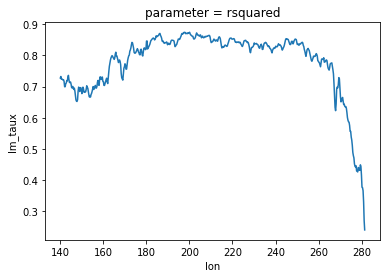

In [6]:
linmodels.lm_taux.sel(parameter='rsquared').plot(x='lon')